In [71]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [72]:
import numpy as np
import pandas as pd
import numpy_groupies as npg

import scipy as sp
import scipy.signal

import itertools
import string
import pickle
import glob
import os
import re 

import tqdm as tqdm

import matplotlib as mpl
import matplotlib.ticker as mticker
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

from collections import defaultdict

from utils.pac import morph_cohort_pac_heatmap, morph_electrode_counter
from utils.surf import create_adjacency, create_distance_matrix, convert_matrix_indices, smooth_adjacent_values, impute_adjacent_values
from utils.io import load_mop, load_electrodes, load_montage, fix_mop, load_psd_data, is_bipolar, read_seeg_parcel_names
from utils.pac import compute_noise_with_notch
from utils.stats import bootstrap_statistic, interpolate_linear, bootstrap_n_peaks
from utils.fooof_utils import get_foofed_spectrum_chanwise
from utils.vis_3d import BrainSurface
from utils.colors import okabe, subsystem_to_color
from utils.peaks import build_peaks_map, detect_anatomy_peaks
from utils.plot import draw_four_views
from utils.pyutils import get_subsystem, convert_to_array
from utils.colors import CmapPruned
from crosspy.core.autocorrelation import get_length_by_cdf

%config InlineBackend.figure_format = 'jpg'

In [73]:
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=okabe)

In [74]:
def create_subsystem_map(values):
    res = dict()
    
    for v in values:
        if not(v in res):
            res[v] = len(res)
    
    return res

def get_subsystem_hemi(name):
    name = name.split('_')[2]
    
    return name

In [75]:
n_cortical = 400
lags_cycles = np.arange(200)/10

subsystem_to_system = np.array([0, 0, 
                                1, 1, 
                                2, 2, 
                                3, 3, 
                                4, 4, 
                                5, 5,5 ,
                                6,6,6,
                                7])


In [76]:
fsaverage_path = r'L:\nttk-data2\palva\Common repos\_fsaverage\fsaverage'
data_root = '../seeg_phases/data/SEEG_redux_BIDS/'

df_num_idx = pd.read_csv('meso_data/convert_results.csv').set_index('subject_number')

In [77]:
pial_rh_fname = 'meso_data/fsaverage6/surf/rh.pial'
inflated_rh_fname = 'meso_data/fsaverage6/surf/rh.inflated'
annot_rh_fname = f'meso_data/fsaverage6/label/rh.Schaefer2018_{n_cortical}Parcels_17Networks_order.annot'

pial_lh_fname = 'meso_data/fsaverage6/surf/lh.pial'
inflated_lh_fname = 'meso_data/fsaverage6/surf/lh.inflated'
annot_lh_fname = f'meso_data/fsaverage6/label/lh.Schaefer2018_{n_cortical}Parcels_17Networks_order.annot'

In [78]:
seeg_parcels = read_seeg_parcel_names(n_cortical)
cortical_parcels = [n for n in seeg_parcels[-402:] if not('unknown' in n.lower() or 'background' in n.lower())]
cortical_subsystems = np.array([get_subsystem_hemi(n) for n in cortical_parcels])

subsystem_to_index = create_subsystem_map(cortical_subsystems)
subsystem_indices = np.array([subsystem_to_index[s] for s in cortical_subsystems])

unk_idx = [idx for (idx, n) in enumerate(seeg_parcels[-402:]) if ('unknown' in n.lower()) or ('background' in n.lower())]

In [79]:
adjacency_lh_orig = create_adjacency(inflated_lh_fname, annot_lh_fname, offset=0, n_parcels=n_cortical)
adjacency_matrix_lh = convert_matrix_indices(adjacency_lh_orig, annot_lh_fname, np.delete(seeg_parcels[-402:], unk_idx), offset=0)

adjacency_rh_orig = create_adjacency(inflated_rh_fname, annot_rh_fname, offset=0, n_parcels=n_cortical)
adjacency_matrix_rh = convert_matrix_indices(adjacency_rh_orig, annot_rh_fname, np.delete(seeg_parcels[-402:], unk_idx), offset=n_cortical//2)

adjacency_matrix = adjacency_matrix_lh |  adjacency_matrix_rh

In [80]:
res_path = os.path.join('meso_data', 'pac_signal_frequency_7.5', 'pac_sub*.pickle')
res_files = glob.glob(res_path)

print(len(res_files))

68


In [81]:
brain_surf_lh = BrainSurface(fsaverage_path, parcellation='Schaefer2018_400Parcels_17Networks_order', 
                             hemis=['lh'], surface='inflated')
brain_surf_rh = BrainSurface(fsaverage_path, parcellation='Schaefer2018_400Parcels_17Networks_order', 
                             hemis=['rh'], surface='inflated')

surf_parcel_names = brain_surf_lh.parcel_names[1:] + brain_surf_rh.parcel_names[1:]
brain_3d_surfaces = [brain_surf_lh, brain_surf_rh]

In [82]:
bad_subjects = ['02', # weird mop
                '06',
                '40',
                '42',
                '57',
                '60',# too short
               ] 

In [83]:
meta_data_subjects = pickle.load(open('meso_data/meta_data_subjects.pickle', 'rb'))

In [84]:
cohort_pacf_lifetime = list()
noise_channelwise_lengths = list()
data_parcels = list()


for fname in res_files:
    base_name = os.path.split(fname)[~0]
    subj_num = re.findall(r'\d+', base_name)[0]
    subj_name = df_num_idx.loc[int(subj_num)]['name']
    
    if subj_num in  bad_subjects:
        print('passing', subj_num)
        continue
    
    subj_montage = meta_data_subjects[subj_num]['montage']
    
    bipolar_mask = subj_montage['name'].apply(is_bipolar)
    subj_montage = subj_montage[bipolar_mask]
    subj_chans = subj_montage['name'].tolist()

    subj_mop = meta_data_subjects[subj_num]['mop']
    subj_mop = fix_mop(subj_mop, bipolar_mask)
    subj_parcels = subj_mop['parcel_assign']
    
    subj_res = pickle.load(open(fname, 'rb'))
    f_vals = np.array(subj_res['f_vals'])
    
    if subj_res['data_pac'].shape[1] != subj_montage.shape[0] or subj_num in bad_subjects:
        print('passing', subj_num)
        continue
        
    if np.array_equal(subj_chans, subj_mop['channel_names']) == False:
        index_mapper = [subj_chans.index(n) for n in subj_mop['channel_names']]
        subj_parcels = subj_parcels[index_mapper]
        
        
    subj_lengths_channelwise = np.array([np.apply_along_axis(lambda arr: get_length_by_cdf(arr, lags_cycles, 0.9), 1, pac)
                    for pac in subj_res['data_pac']])
    
    subj_noise_lengths_channelwise = np.array([np.apply_along_axis(lambda arr: get_length_by_cdf(arr, lags_cycles, 0.9), 1, pac) 
                     for pac in subj_res['noise_pac']])
    
    
    cohort_pacf_lifetime.append(subj_lengths_channelwise)
    noise_channelwise_lengths.append(subj_noise_lengths_channelwise)    
    data_parcels.append(subj_parcels)

passing 02
passing 06


d:\Vlad\Anaconda3\envs\seeg_meso_env\lib\site-packages\crosspy-0.0.1b0-py3.7.egg\crosspy\core\autocorrelation.py:27: RuntimeWarning: invalid value encountered in true_divide


passing 19
passing 40
passing 42
passing 57
passing 60


In [85]:
data_parcels = convert_to_array(data_parcels)
channelwise_lengths = convert_to_array(cohort_pacf_lifetime)
noise_channelwise_lengths = convert_to_array(noise_channelwise_lengths)

noise_level = np.percentile(np.concatenate(noise_channelwise_lengths, axis=-1), 99, axis=-1)

In [86]:
morphed_counter = np.array([morph_electrode_counter(subj_mop, 493) for subj_mop in data_parcels])
morphed_counter = np.nansum(morphed_counter, axis=0)

counter_known = np.delete(morphed_counter[-402:], [0,201])

In [87]:
peak_freq_subjects, cortical_peak_map, n_peaks_subjects = detect_anatomy_peaks(channelwise_lengths, data_parcels, noise_level, f_vals)

In [88]:
peak_freq_subjects_known = np.delete(peak_freq_subjects[-402:], [0,201])


peak_map_known = np.delete(cortical_peak_map[:, -402:], [0, 201], axis=1)
peak_map_normed = peak_map_known / peak_map_known.sum(axis=0, keepdims=True)
peak_map_system = npg.aggregate(subsystem_indices, peak_map_normed, axis=-1, func='nanmean')

cortical_peaks_boot = bootstrap_n_peaks(n_peaks_subjects, data_parcels)
cortical_peaks_boot_known = np.delete(cortical_peaks_boot[..., -402:], unk_idx, axis=-1)

cortical_peaks_boot_normed = cortical_peaks_boot_known / cortical_peaks_boot_known.sum(axis=1, keepdims=True)
cortical_peaks_boot_system = npg.aggregate(subsystem_indices, cortical_peaks_boot_normed, axis=-1, func='nanmean')

C:\Users\vlamyr\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """
C:\Users\vlamyr\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


In [89]:
seeg_peaks_map = build_peaks_map(peak_freq_subjects_known, counter_known)
(single_peaks_map, single_peaks_map_counter, single_peaks_flat), (multi_peaks_map, multi_peaks_map_counter, multi_peaks_flat), (merged_peaks_map, merged_peaks_map_counter, merged_peaks_flat) = seeg_peaks_map

In [90]:
meg_pac_results = pickle.load(open('meso_data/meg_pac_results_full.pickle', 'rb'))

meg_orig_parcel_names = [n.split('-')[0] for n in meg_pac_results['parcel_names']]
meg_average_pac = meg_pac_results['average_pac']
meg_parcels = [np.arange(400) for _ in range(meg_average_pac.shape[0])]
meg_counter = np.full(counter_known.shape, meg_average_pac.shape[0])

In [91]:
peak_freq_subjects_meg, cortical_peak_map_meg, n_peaks_subjects_meg = detect_anatomy_peaks(meg_average_pac, meg_parcels, noise_level, f_vals)
peak_freq_subjects_meg = peak_freq_subjects_meg[:n_cortical]
cortical_peak_map_meg = cortical_peak_map_meg[..., :n_cortical]

meg_peaks_map = build_peaks_map(peak_freq_subjects_meg, meg_counter, alpha_band=(0,15), beta_band=(15,30))
(single_peaks_map_meg, single_peaks_map_counter_meg, single_peaks_flat_meg), (multi_peaks_map_meg, multi_peaks_map_counter_meg, multi_peaks_flat_meg), (merged_peaks_map_meg, merged_peaks_map_counter_meg, merged_peaks_flat_meg) = meg_peaks_map

In [92]:
yeo17_cmap = plt.get_cmap('tab20c')

yeo17_colors = [yeo17_cmap.colors[subsystem_to_color[get_subsystem(n)]] + (1.0,) for n in surf_parcel_names]

yeo17_tick_labels = ['']*20

for key, value in subsystem_to_color.items():
    yeo17_tick_labels[value] = key

In [93]:
meg_to_seeg_idx = [sorted(surf_parcel_names).index(v) for v in surf_parcel_names]

data_parcels_meg = [np.arange(400) for _ in range(len(meg_average_pac))]

peak_map_normed_meg = cortical_peak_map_meg / cortical_peak_map_meg.sum(axis=0, keepdims=True)
peak_map_system_meg = npg.aggregate(subsystem_indices, peak_map_normed_meg, axis=-1, func='nanmean')

cortical_peaks_boot_meg = bootstrap_n_peaks(n_peaks_subjects_meg, data_parcels_meg, n_cortical=n_cortical-93)

cortical_peaks_boot_normed_meg = cortical_peaks_boot_meg / cortical_peaks_boot_meg.sum(axis=1, keepdims=True)
cortical_peaks_boot_system_meg = npg.aggregate(subsystem_indices, cortical_peaks_boot_normed_meg[..., meg_to_seeg_idx], axis=-1, func='nanmean')

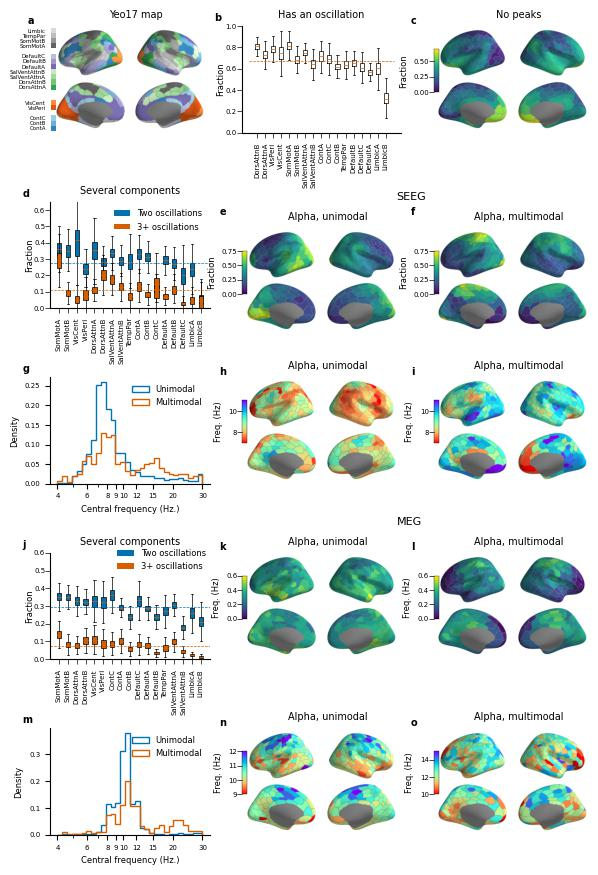

In [95]:

parcels_orig = np.array(list(subsystem_to_index.keys()))
legend_objects = list()

fig = plt.figure(figsize=(7,10.5), dpi=100, constrained_layout=False)
main_spec = fig.add_gridspec(nrows=5, ncols=3, hspace=0.65)

axes = np.empty((10,6), dtype=object)

axes[0,2] = fig.add_subplot(main_spec[0,1])
axes[2,0] = fig.add_subplot(main_spec[1,0])
axes[4,0] = fig.add_subplot(main_spec[2,0])
axes[6,0] = fig.add_subplot(main_spec[3,0])
axes[8,0] = fig.add_subplot(main_spec[4,0])


for i, j in itertools.product([0], [0,2]):
    brain_gs = main_spec[i,j].subgridspec(2,2, wspace=0, hspace=0)
    for nr, nc in itertools.product(range(2), range(2)):
        axes[i*2+nr, j*2+nc] = fig.add_subplot(brain_gs[nr,nc])

for i, j in itertools.product(range(1,5), range(1,3)):
    brain_gs = main_spec[i,j].subgridspec(2,2, wspace=0, hspace=0)
    for nr, nc in itertools.product(range(2), range(2)):
        axes[i*2+nr, j*2+nc] = fig.add_subplot(brain_gs[nr,nc])

for i, (ax, title) in enumerate(zip([axes[0,2], axes[2,0], axes[2,0]], 
                                    ['Has an oscillation', 
                                     'Several components',
                                     'Several components'])):
    if i == 0: # has at least one oscillation
        values = cortical_peaks_boot_system[:, 1:].sum(axis=1)  
        system_mean = npg.aggregate(subsystem_to_system, values.mean(axis=0), func='mean')[subsystem_to_system]
        sorting_values = list(zip(system_mean, values.mean(axis=0)))
        sorted_values = sorted(enumerate(sorting_values), key=lambda x: x[1], reverse=True)

        idx_sorted = [v[0] for v in sorted_values]
    elif i == 1: #has just one oscillation
        values = cortical_peaks_boot_system[:, 2]/cortical_peaks_boot_system[:, 1:].sum(axis=1)

        system_mean = npg.aggregate(subsystem_to_system, values.mean(axis=0), func='mean')[subsystem_to_system]
        sorting_values = list(zip(system_mean, values.mean(axis=0)))
        sorted_values = sorted(enumerate(sorting_values), key=lambda x: x[1], reverse=True)

        idx_sorted = [v[0] for v in sorted_values]
    else: # has 2+ oscillations
        values = cortical_peaks_boot_system[:, 3:].sum(axis=1)/cortical_peaks_boot_system[:, 1:].sum(axis=1)
    
    bp = ax.boxplot(values[:, idx_sorted], showfliers=False, labels=parcels_orig[idx_sorted], patch_artist=bool(i), 
                    boxprops={'linewidth':0.5}, whiskerprops={'linewidth':0.5}, medianprops={'linewidth':0.5}, capprops={'linewidth':0.5})

    mean_color = okabe[0] if i == 1 else okabe[1] 
    ax.hlines(values.mean(), 0, 18, ls='--', lw=0.5, color=mean_color)
    
    if i in (0,1):
        ax.set_title(title, fontsize=7)

        ax.set_ylim([0,1])
        ax.tick_params(axis='x', rotation=90, labelsize=5, width=0.5)
        ax.tick_params(axis='y', labelsize=5, width=0.5, pad=0.1)
        
    if i == 1:
        ax.set_xticks([])
        ax.set_xticklabels([])
        
    if i in (1,2):
        legend_objects.append(bp['boxes'][0])
        
        color = okabe[0] if i == 1 else okabe[1]
        for patch in bp['boxes']:
            patch.set_facecolor(color)
            
    ax.set_ylabel('Fraction', fontsize=6, labelpad=0)

         
axes[4, 0].hist(single_peaks_flat, bins=np.geomspace(4,30,31), density=True, histtype='step', label='Unimodal')
axes[4, 0].hist(multi_peaks_flat, bins=np.geomspace(4,30,31), density=True, histtype='step', label='Multimodal')


for i, (ax, title) in enumerate(zip([axes[6,0], axes[6,0]], 
                                    ['Several components',
                                     'Several components'])):
    if i == 0: #has just two oscillations
        values = cortical_peaks_boot_system_meg[:, 2]/cortical_peaks_boot_system_meg[:, 1:].sum(axis=1)

        system_mean = npg.aggregate(subsystem_to_system, values.mean(axis=0), func='mean')[subsystem_to_system]
        sorting_values = list(zip(system_mean, values.mean(axis=0)))
        sorted_values = sorted(enumerate(sorting_values), key=lambda x: x[1], reverse=True)

        idx_sorted = [v[0] for v in sorted_values]
    else: # has 3+ oscillations
        values = cortical_peaks_boot_system_meg[:, 3:].sum(axis=1)/cortical_peaks_boot_system_meg[:, 1:].sum(axis=1)
    
    bp = ax.boxplot(values[:, idx_sorted], showfliers=False, labels=parcels_orig[idx_sorted], patch_artist=True, 
                    boxprops={'linewidth':0.5}, whiskerprops={'linewidth':0.5}, medianprops={'linewidth':0.5}, capprops={'linewidth':0.5})

    mean_color = okabe[0] if i == 0 else okabe[1] 
    ax.hlines(values.mean(), 0, 18, ls='--', lw=0.5, color=mean_color)
    
    if i in (0,1):
        ax.set_title(title, fontsize=7)

        ax.set_ylim([0,1])
        ax.tick_params(axis='x', rotation=90, labelsize=5, width=0.5)
        ax.tick_params(axis='y', labelsize=5, width=0.5, pad=0.1)
        
    if i == 0:
        ax.set_xticks([])
        ax.set_xticklabels([])
        
    if i in (0,1):
        legend_objects.append(bp['boxes'][0])
        
        color = okabe[0] if i == 0 else okabe[1]
        for patch in bp['boxes']:
            patch.set_facecolor(color)
            
    ax.set_ylabel('Fraction', fontsize=6, labelpad=0)

legend_elements = [Patch(facecolor=okabe[0], label='Two oscillations'),
                   Patch(facecolor=okabe[1], label='3+ oscillations')]

axes[2,0].legend(handles=legend_elements, frameon=False, fontsize=6)
axes[6,0].legend(handles=legend_elements, frameon=False, fontsize=6, loc=(0.4, 0.8))

axes[8, 0].hist(single_peaks_flat_meg, bins=np.geomspace(4,30,31), density=True, histtype='step', label='Unimodal')
axes[8, 0].hist(multi_peaks_flat_meg, bins=np.geomspace(4,30,31), density=True, histtype='step', label='Multimodal')


for ax in [axes[4,0], axes[8,0]]:
    ax.set_xscale('log')

    ax.xaxis.set_minor_formatter(mticker.NullFormatter())
    ax.xaxis.set_major_formatter(mticker.ScalarFormatter())

    ax.set_xlabel('Central frequency (Hz.)', fontsize=6)
    ax.set_ylabel('Density', fontsize=6)
    ax.tick_params(labelsize=5, axis='both')
    ax.legend(fontsize=6, frameon=False)

    ax.set_xticks([4,6,8,9,10,12,15,20,30])
    

values = smooth_adjacent_values(peak_map_normed[0], counter_known, adjacency_matrix)
draw_four_views(axes[0:2, 4:6], values, surf_parcel_names, brain_3d_surfaces, title_kwargs={'fontsize': 7},
                cmap='viridis', title='No peaks', norm_values=[0.0, 0.7])


# SEEG PREVALENCE

values =  single_peaks_map_counter[:,0].copy()
values = smooth_adjacent_values(values, single_peaks_map_counter[:,0], adjacency_matrix, replace_na=True)
norm_values = [0,.75]

draw_four_views(axes[2:4, 2:4], values, surf_parcel_names, brain_3d_surfaces, title_kwargs={'fontsize': 7},
                cmap='viridis', title='Alpha, unimodal', norm_values=norm_values)

values =  multi_peaks_map_counter[:,0].copy()
values = smooth_adjacent_values(values, multi_peaks_map_counter[:,0], adjacency_matrix, replace_na=True)

draw_four_views(axes[2:4, 4:6], values, surf_parcel_names, brain_3d_surfaces, title_kwargs={'fontsize': 7},
                cmap='viridis', title='Alpha, multimodal', norm_values=norm_values)

# SEEG FREQS

values =  single_peaks_map[:,0].copy()
values = smooth_adjacent_values(values, single_peaks_map_counter[:,0], adjacency_matrix, replace_na=True)


norm_values = [7,11]

draw_four_views(axes[4:6, 2:4], values, surf_parcel_names, brain_3d_surfaces, title_kwargs={'fontsize': 7},
                cmap='rainbow_r', title='Alpha, unimodal', norm_values=norm_values)

values =  multi_peaks_map[:,0].copy()
values = smooth_adjacent_values(values, multi_peaks_map_counter[:,0], adjacency_matrix, replace_na=True)

draw_four_views(axes[4:6, 4:6], values, surf_parcel_names, brain_3d_surfaces, title_kwargs={'fontsize': 7},
                cmap='rainbow_r', title='Alpha, multimodal', norm_values=norm_values)

# MEG PREVALENCE

values =  single_peaks_map_counter_meg[:,0].copy()
norm_values = [0,.6]

draw_four_views(axes[6:8, 2:4], values[np.argsort(meg_pac_results['parcel_names'])], sorted(surf_parcel_names), brain_3d_surfaces, title_kwargs={'fontsize': 7},
                cmap='viridis', title='Alpha, unimodal', norm_values=norm_values)

values =  multi_peaks_map_counter_meg[:,0].copy()

draw_four_views(axes[6:8, 4:6], values[np.argsort(meg_pac_results['parcel_names'])], sorted(surf_parcel_names), brain_3d_surfaces, title_kwargs={'fontsize': 7},
                cmap='viridis', title='Alpha, multimodal', norm_values=norm_values)


# MEG FREQS

values =  single_peaks_map_meg[:,0].copy()
norm_values = [9.0, 12.0]


draw_four_views(axes[8:10, 2:4], values[meg_to_seeg_idx], surf_parcel_names, brain_3d_surfaces, title_kwargs={'fontsize': 7},
                cmap='rainbow_r', title='Alpha, unimodal', norm_values=norm_values)

values =  multi_peaks_map_meg[:,0].copy()
norm_values = [10.0, 15.0]
draw_four_views(axes[8:10, 4:6], values[meg_to_seeg_idx], surf_parcel_names, brain_3d_surfaces, title_kwargs={'fontsize': 7},
                cmap='rainbow_r', title='Alpha, multimodal', norm_values=norm_values)

# YEO 17

draw_four_views(axes[:2,:2], yeo17_colors, surf_parcel_names, brain_3d_surfaces, title_kwargs={'fontsize': 7},
                cmap='viridis', title='Yeo17 map', norm_values=[0.0, 0.7], cbar_ax_kwargs={'height': '125%', 'bbox_to_anchor': (-0.15,0.55,0.7,1.55)})

custom_cmap = CmapPruned(plt.get_cmap('tab20c'), prune_idx=[3,6,7,15])

cb = mpl.colorbar.ColorbarBase(fig.axes[~0], cmap=custom_cmap, norm=mpl.colors.Normalize(0,20), drawedges=False)

fig.axes[~0].set_yticks(np.arange(20)+0.5)
fig.axes[~0].set_yticklabels(yeo17_tick_labels)
fig.axes[~0].yaxis.set_ticks_position('left')

fig.axes[~0].tick_params(left=False, labelsize=4, pad=0, width=0.5)
cb.outline.set_visible(False)

for ax in axes[2:4, 2:6].flatten():
    bb = list(ax.get_position().bounds)
    bb[1] -= 0.025

    ax.set_position(bb)

for ax in [axes[0, 2], axes[2,0], axes[4,0], axes[6,0], axes[8,0]]: 
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)


axes[2,0].set_ylim([0,0.65])
axes[6,0].set_ylim([0,0.6])

axes[2,0].set_xlim([0,18])
axes[6,0].set_xlim([0,18])


for ax, ylabel in zip(fig.axes[-10:-1], ['Fraction']*3 + ['Freq. (Hz)']*6):
    ax.yaxis.set_tick_params(labelsize=5, pad=0, width=0.5) 
    ax.set_ylabel(ylabel, fontsize=6)
    ax.yaxis.set_label_position('left')

brain_ax_labels = [axes[0,0], axes[0,4], axes[4,2], axes[4,4], axes[6,2], axes[6,4], axes[8,2], axes[8,4]]
brain_moved_ax_labels = [axes[2,2], axes[2,4]]
ax_labels = [axes[0,2], axes[2,0], axes[4,0], axes[6,0],  axes[8,0]]

fig.text(0.62, 0.715, 'SEEG', fontsize=8)
fig.text(0.62, 0.405, 'MEG', fontsize=8)

for ax, label in zip(brain_ax_labels, 'achiklno'):
    ax.text(-0.375, 1.05, label, fontsize=7, transform=ax.transAxes, weight='bold')

for ax, label in zip(brain_moved_ax_labels, 'ef'):
    ax.text(-0.375, 1.25, label, fontsize=7, transform=ax.transAxes, weight='bold')

for ax, label in zip(ax_labels, 'bdgjm'):
    ax.text(-0.175, 1.05, label, fontsize=7, transform=ax.transAxes, weight='bold')
    
fig.savefig('publication_figures/figure_4.png', dpi=300, bbox_inches="tight")

for format in ['svg', 'pdf']:
    fig.savefig(f'publication_figures_vector/figure_4.{format}', dpi=300, bbox_inches="tight")

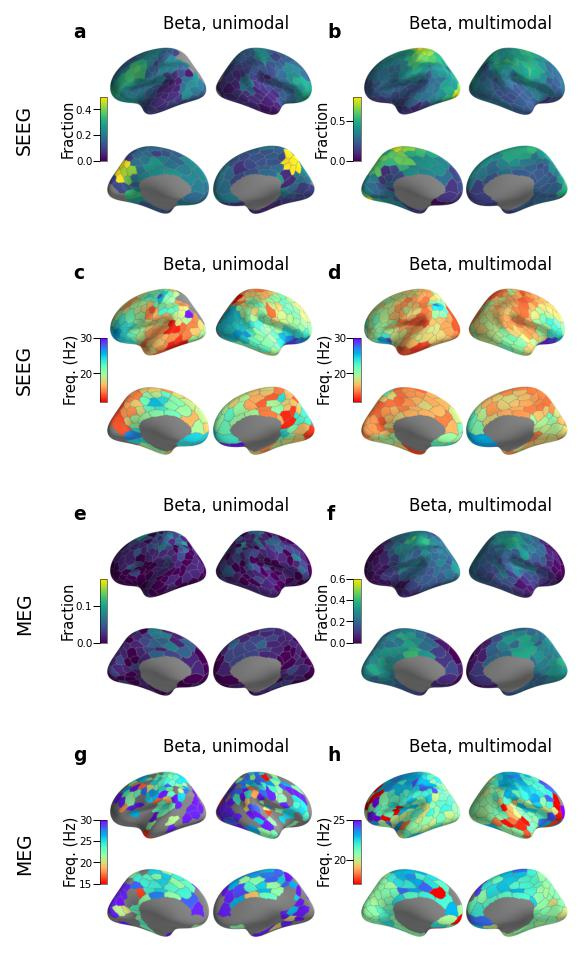

In [96]:
fig = plt.figure(figsize=(4,8), dpi=150, constrained_layout=False)
main_spec = fig.add_gridspec(nrows=4, ncols=2)

axes = np.empty((8,4), dtype=object)

for i, j in itertools.product(range(4), range(2)):
    brain_gs = main_spec[i,j].subgridspec(2,2, wspace=0, hspace=0)
    for nr, nc in itertools.product(range(2), range(2)):
        axes[i*2+nr, j*2+nc] = fig.add_subplot(brain_gs[nr,nc])


# SEEG PREVALENCE

values = single_peaks_map_counter[:,1].copy()
values = smooth_adjacent_values(values, single_peaks_map_counter[:,1], adjacency_matrix, replace_na=True)
norm_values = [0, 0.5]

draw_four_views(axes[0:2, 0:2], values, surf_parcel_names, brain_3d_surfaces, title_kwargs={'fontsize': 8},
                cmap='viridis', title='Beta, unimodal', norm_values=norm_values)

values =  multi_peaks_map_counter[:,1].copy()
values = smooth_adjacent_values(values, multi_peaks_map_counter[:,1], adjacency_matrix, replace_na=True)

norm_values = [0, 0.8]

draw_four_views(axes[0:2, 2:4], values, surf_parcel_names, brain_3d_surfaces, title_kwargs={'fontsize': 8},
                cmap='viridis', title='Beta, multimodal', norm_values=norm_values)

# SEEG FREQS

values =  single_peaks_map[:,1].copy()
values = smooth_adjacent_values(values, single_peaks_map_counter[:,1], adjacency_matrix, replace_na=True)


norm_values = [12.0, 30.0]

draw_four_views(axes[2:4, 0:2], values, surf_parcel_names, brain_3d_surfaces, title_kwargs={'fontsize': 8},
                cmap='rainbow_r', title='Beta, unimodal', norm_values=norm_values)

values =  multi_peaks_map[:,1].copy()
values = smooth_adjacent_values(values, multi_peaks_map_counter[:,1], adjacency_matrix, replace_na=True)

draw_four_views(axes[2:4, 2:4], values, surf_parcel_names, brain_3d_surfaces, title_kwargs={'fontsize': 8},
                cmap='rainbow_r', title='Beta, multimodal', norm_values=norm_values)

# MEG PREVALENCE

values =  single_peaks_map_counter_meg[:,1].copy()
norm_values = [0, 0.175]

draw_four_views(axes[4:6, 0:2], values[np.argsort(meg_pac_results['parcel_names'])], sorted(surf_parcel_names), brain_3d_surfaces, title_kwargs={'fontsize': 8},
                cmap='viridis', title='Beta, unimodal', norm_values=norm_values)

values =  multi_peaks_map_counter_meg[:,1].copy()
norm_values = [0, 0.6]

draw_four_views(axes[4:6, 2:4], values[np.argsort(meg_pac_results['parcel_names'])], sorted(surf_parcel_names), brain_3d_surfaces, title_kwargs={'fontsize': 8},
                cmap='viridis', title='Beta, multimodal', norm_values=norm_values)


# MEG FREQS

values =  single_peaks_map_meg[:,1].copy()
norm_values = [15.0, 30.0]


draw_four_views(axes[6:8, 0:2], values[meg_to_seeg_idx], surf_parcel_names, brain_3d_surfaces, title_kwargs={'fontsize': 8},
                cmap='rainbow_r', title='Beta, unimodal', norm_values=norm_values)


values =  multi_peaks_map_meg[:,1].copy()
norm_values = [17.0, 25.0]

draw_four_views(axes[6:8, 2:4], values[meg_to_seeg_idx], surf_parcel_names, brain_3d_surfaces, title_kwargs={'fontsize': 8},
                cmap='rainbow_r', title='Beta, multimodal', norm_values=norm_values)


for ax, ylabel in zip(fig.axes[-8:], ['Fraction']*2 + ['Freq. (Hz)']*2 + ['Fraction']*2 + ['Freq. (Hz)']*2):
    ax.yaxis.set_tick_params(labelsize=5, pad=0, width=0.5) 
    ax.set_ylabel(ylabel, fontsize=7, labelpad=0.0)
    ax.yaxis.set_label_position('left')


ax_labels = [axes[0,0], axes[0,2], axes[2,0], axes[2,2], axes[4,0], axes[4,2], axes[6,0], axes[6,2]]
for ax, label in zip(ax_labels, string.ascii_lowercase):
    ax.text(-0.3, 1.05, label, fontsize=9, transform=ax.transAxes, weight='bold')

for ypos, label in zip([0.18, 0.38, 0.58, 0.78], ['MEG' , 'MEG', 'SEEG', 'SEEG']):
    fig.text(-0.025, ypos, label, rotation=90, fontsize=9)

fig.savefig('publication_figures/figure_4_supp.png', dpi=300, bbox_inches="tight")